# Проект 4. Компьютер говорит 'Нет'

# 1. Подключаем библиотеки

In [870]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline

/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv


# 2. Определяем классы и функции

In [871]:
class LogDf():
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 

class NumFitInspect():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))

        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax1)
        fig.suptitle('QQ-plot, histogram and boxplot for {0} '.format(column))
        
        ax2.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'green')
        ax3.boxplot(data.dropna(), vert = False)  
     
        plt.show
        
    def boundaries(self, log = False):
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def outliers(self, log = False):
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.boundaries(log)
        return len(data[data < minb])+ len(data[data > maxb])


In [872]:
class ModelInspect():
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'Pastel1', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default без регуляризации')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)

        plt.show()
                                          


# 3. Импортируем данные

In [873]:
data_directory = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [874]:
# зафиксируем константы
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [875]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['Train'] = 1 # помечаем где у нас трейн
data_test['Train'] = 0 # помечаем где у нас тест

data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем

In [876]:
print('размерность тренировочного датасета: ', data_train.shape, '\n')
print('размерность тестовго датасета: ', data_test.shape)

размерность тренировочного датасета:  (73799, 20) 

размерность тестовго датасета:  (36349, 19)


In [877]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

В тренировочном наборе 73799 записей, в тестовой - 36349. Всего 19 переменных (18 признаков + целевая).

# 4. Выполняем предварительный анализ данных

In [878]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
110142,72405,20MAR2014,SCH,F,40,N,N,0,0,-2.039905,0,50,2,3,20000,4,1,N,NaN,0
41648,6396,13JAN2014,GRD,F,62,N,N,0,0,-1.266995,3,80,2,3,35000,1,2,Y,0.0,1
37128,1548,06JAN2014,SCH,F,50,N,N,0,0,-2.094780,2,40,2,3,15000,1,3,N,1.0,1
29097,28218,04FEB2014,GRD,F,26,N,N,0,0,-1.767267,1,60,2,3,35000,2,3,N,0.0,1
33380,3142,09JAN2014,SCH,M,49,N,N,2,0,-1.072924,2,60,1,3,30000,1,3,N,0.0,1


In [879]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

В поле education имеются пропуски. <br>
Пропуски в default - у тестовой выборки, их нужно предсказать. <br>
default - целевая переменная.

In [880]:
data.describe(include = 'object')

,app_date,education,sex,car,car_type,foreign_passport
count,110148,109670,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,57998,61836,74290,89140,93721


In [881]:
# посмотрим на значения в строковых полях
cols = data.columns
for col in cols:
    if data[col].dtype == 'O':
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле app_date : ['01FEB2014' '12MAR2014' '23JAN2014' '18APR2014' '18FEB2014' '04FEB2014'
 '17MAR2014' '14FEB2014' '10JAN2014' '03FEB2014' '08APR2014' '08JAN2014'
 '19MAR2014' '22JAN2014' '30JAN2014' '11MAR2014' '02FEB2014' '14APR2014'
 '06JAN2014' '24MAR2014' '15APR2014' '28FEB2014' '11FEB2014' '30MAR2014'
 '23MAR2014' '09MAR2014' '02MAR2014' '31JAN2014' '14MAR2014' '26JAN2014'
 '03APR2014' '22MAR2014' '11JAN2014' '17FEB2014' '13FEB2014' '17APR2014'
 '25FEB2014' '10APR2014' '01APR2014' '21APR2014' '20MAR2014' '03MAR2014'
 '25MAR2014' '24FEB2014' '16APR2014' '27FEB2014' '18MAR2014' '19FEB2014'
 '20FEB2014' '31MAR2014' '04MAR2014' '25JAN2014' '07JAN2014' '07MAR2014'
 '26MAR2014' '05FEB2014' '06MAR2014' '08FEB2014' '21JAN2014' '13MAR2014'
 '09JAN2014' '07FEB2014' '29JAN2014' '27JAN2014' '15FEB2014' '29APR2014'
 '04APR2014' '16JAN2014' '07APR2014' '13JAN2014' '21MAR2014' '24JAN2014'
 '27MAR2014' '09FEB2014' '06FEB2014' '22FEB2014' '28JAN2014' '28APR2014'
 '10FEB2014' 

Мусора в строковых данных нет. <br>
В поле education нужно заполнить или удалить пропуски. <br>
Поле app_date содержит дату. Как есть, его использовать нельзя. Сконструируем на его основе новые признаки.

In [882]:
# Выпишем категориальные и бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']
cat_cols = ['education']

### 4.1. Заполним пропуски в education

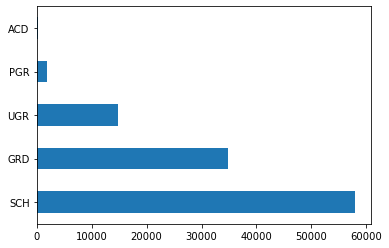

In [883]:
data.education.value_counts().plot.barh()

In [884]:
mode = data.education.mode()[0]
print('Самое частое значение в поле Education: ', mode)

Самое частое значение в поле Education:  SCH


In [885]:
# Заполним пропуски в education модой

data['education'].fillna(mode, inplace=True)
data.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [886]:
# Проверим
data.education.value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

### 4.2. Обработаем app_date

In [887]:
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')
data['app_date'].sample(5)

99117   2014-01-25
38449   2014-01-31
66009   2014-01-25
50059   2014-03-22
96612   2014-01-04
Name: app_date, dtype: datetime64[ns]

In [888]:
data['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

Все заявки из датасета поданы в 2014 году.

In [889]:
data['app_date'].dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

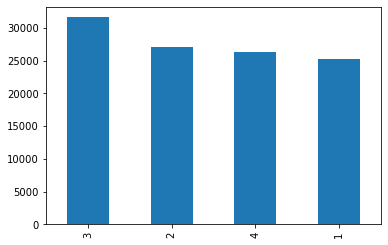

In [890]:
data['app_date'].dt.month.value_counts().plot.bar()

Все заявки приблизительно равномерно распределены между 4 месяцами.

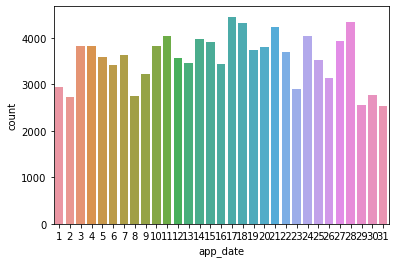

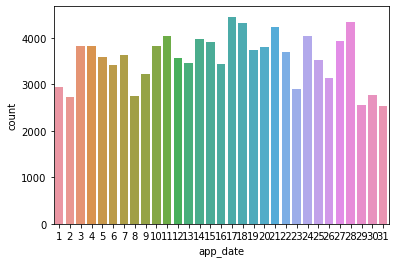

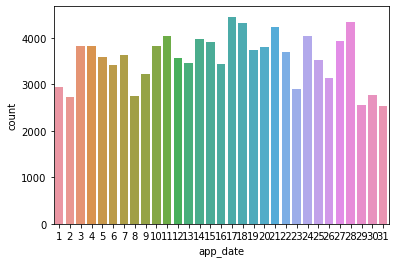

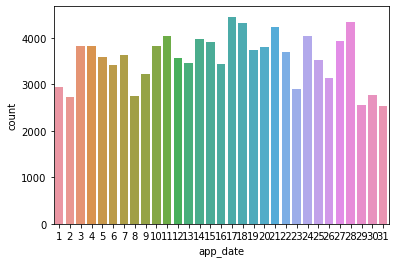

In [891]:
data['month'] = data['app_date'].dt.month
for i in [1,2,3,4]:
    plt.figure()
    sns.countplot(x=data['app_date'].dt.day, data=data[data.month == i])
    plt.show()

Заявки по дням месяцев распределены приблизительно равномерно. Сильных перекосов нет.

Создадим новую переменную - количество дней от 01.01.2014.

In [892]:
NY = pd.to_datetime('01/01/2014')
NY

Timestamp('2014-01-01 00:00:00')

In [893]:
data['days_from_ny'] = (data['app_date'] - NY).dt.days
data[data.month == 1]['days_from_ny'].sample(5)

43522    16
97103    26
6803     28
35565    22
95858    25
Name: days_from_ny, dtype: int64

Итак, мы сконструировали новые признаки на основании app_data:
- month - месяц заявки
- days_from_ny - количество дней от 01.01.2014


Посмотрим на линейную зависимость между этими признаками

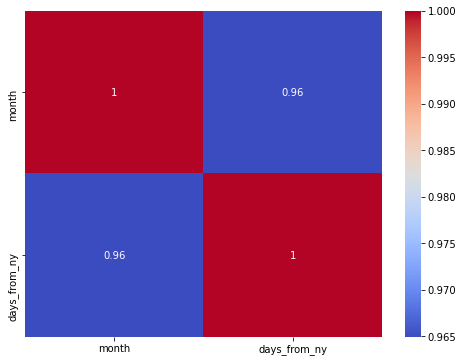

In [894]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,['month', 'days_from_ny']].corr(),annot = True, cmap = 'coolwarm')

Признаки очень сильно линейно-зависимы, поэтому один из них, month, мы использовать не будем.

In [895]:
# Удалим из датасета признак app_date
data.drop(['app_date', 'month'],  axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

### 4.3. Обработаем числовые признаки

In [896]:
# посмотрим на числовые признаки
# проверим, есть ли среди них категориальные
cols = data.columns
for col in cols:
    if data[col].dtype != 'O' and len(data[col].unique())<=20:
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле good_work : [0 1]
Уникальные значения в поле region_rating : [50 80 60 40 70 20 30]
Уникальные значения в поле home_address : [1 2 3]
Уникальные значения в поле work_address : [2 3 1]
Уникальные значения в поле sna : [4 1 2 3]
Уникальные значения в поле first_time : [1 4 3 2]
Уникальные значения в поле default : [ 0.  1. nan]
Уникальные значения в поле Train : [1 0]


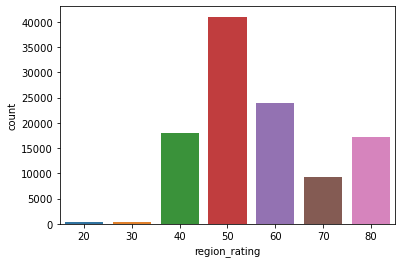

In [897]:
sns.countplot(x=data['region_rating'], data=data)

Признак region_rating похож скорее на категориальный, чем на числовой. Обработаем его как категориальный.

In [898]:
# Дополним бинарные и категориальные признаки
cat_cols += ['region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols += ['good_work']

In [899]:
# Посмотрим на признак client_id
data.client_id.astype('object').describe(include = 'object')

count     110148
unique    110148
top       110148
freq           1
Name: client_id, dtype: int64

Поле client_id - уникальный идентификатор клиента, не повторяется. Смысловой нагрузки не несет, можно выбросить из датасета.

In [900]:
data.drop(['client_id'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  object 
 1   sex               110148 non-null  object 
 2   age               110148 non-null  int64  
 3   car               110148 non-null  object 
 4   car_type          110148 non-null  object 
 5   decline_app_cnt   110148 non-null  int64  
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  int64  
 9   region_rating     110148 non-null  int64  
 10  home_address      110148 non-null  int64  
 11  work_address      110148 non-null  int64  
 12  income            110148 non-null  int64  
 13  sna               110148 non-null  int64  
 14  first_time        110148 non-null  int64  
 15  foreign_passport  110148 non-null  object 
 16  default           73

In [901]:
print('Бинарные признаки: ',bin_cols)
print('Категориальные признаки :',cat_cols)

Бинарные признаки:  ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
Категориальные признаки : ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']


In [902]:
# Выпишем числовые признаки

num_cols = set(data.columns) - set(bin_cols + cat_cols + ['default', 'Train'])
print('Числовые признаки: ', num_cols)

Числовые признаки:  {'bki_request_cnt', 'days_from_ny', 'age', 'decline_app_cnt', 'income', 'score_bki'}


In [903]:
num_cols = list(num_cols)
num_cols

['bki_request_cnt',
 'days_from_ny',
 'age',
 'decline_app_cnt',
 'income',
 'score_bki']

#### 4.3.1. age

In [904]:
# Построим графики для age
data_age = NumFitInspect(data[data.Train == 1], 'age')

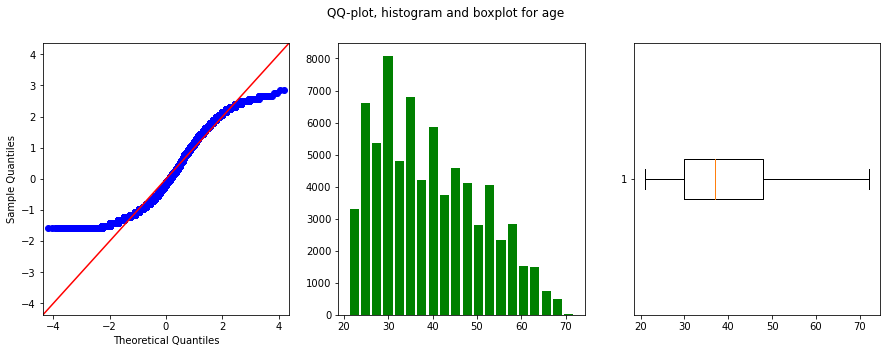

In [905]:
data_age.show_plots()

Признак распределен нормально, выбросов нет.

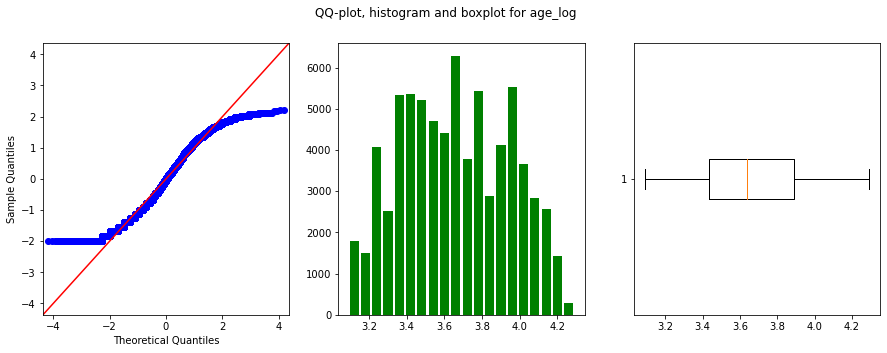

In [906]:
# посмотрим на графики  log(age) 
data_age.show_plots(log = True)

После логарифмирования  признак age стал менее смещёнными. 

In [907]:
# логарифмируем признак age
data['age'] = np.log(data['age'] + 1)
data['age'].sample(5)

12945    3.465736
15696    3.367296
84487    3.988984
64925    3.988984
93628    3.891820
Name: age, dtype: float64

***Заключение для age***: распределение нормальное, выбросов нет, взяли логарифм от признака

#### 4.3.2. decline_app_cnt

In [908]:
# Построим графики для decline_app_cnt
data_decline_app_cnt = NumFitInspect(data[data.Train == 1], 'decline_app_cnt')

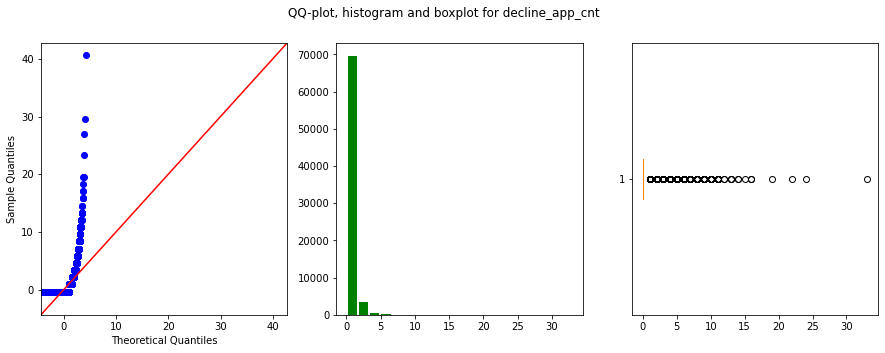

In [909]:
data_decline_app_cnt.show_plots()

Мы наблюдаем сильное смещение. Применим логарифмирование и посмотрим, что получилось

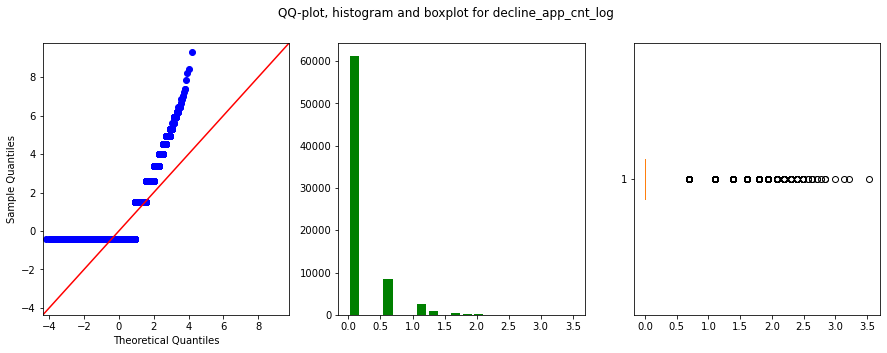

In [910]:
data_decline_app_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным. <br>
Посмотрим на выбросы.

In [911]:
print('Суммарное количество выбросов для decline_app_cnt: ', data_decline_app_cnt.outliers())
print('Суммарное количество выбросов для log(decline_app_cnt): ', data_decline_app_cnt.outliers(log = True))

Суммарное количество выбросов для decline_app_cnt:  12585
Суммарное количество выбросов для log(decline_app_cnt):  12585


Логарифмирование не повлияло на количество выбросов.

In [912]:
# логарифмируем признак decline_app_cnt
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['decline_app_cnt'].sample(5)

95333     0.0
87385     0.0
103182    0.0
4180      0.0
58139     0.0
Name: decline_app_cnt, dtype: float64

***Заключение по decline_app_cnt*** : распределение нормальное, очень сильно смещенное (так, что даже логарифмирование это не особо исправило), взяли логарифм, выбросов очень много даже после логарифмирования, поэтому удалять их пока не будем. Посмотрим влияение выбросов на модель в дальнейшем.

4.3.3. income

In [913]:
# Построим графики для income
data_income = NumFitInspect(data[data.Train == 1], 'income')

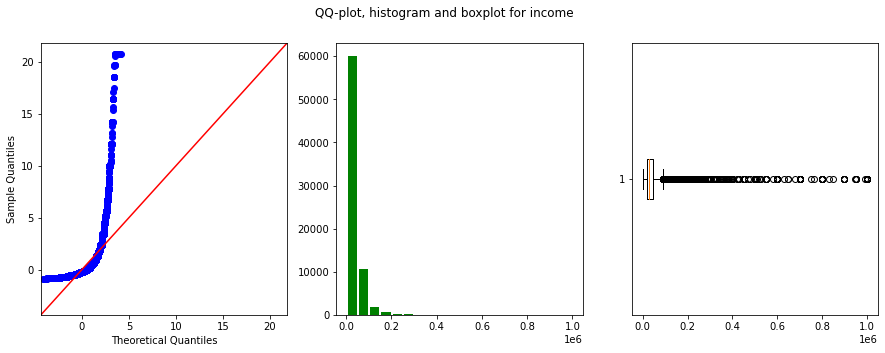

In [914]:
data_income.show_plots()

Признак очень смещен. Много выбросов. <br> Посмотрим на log(income)

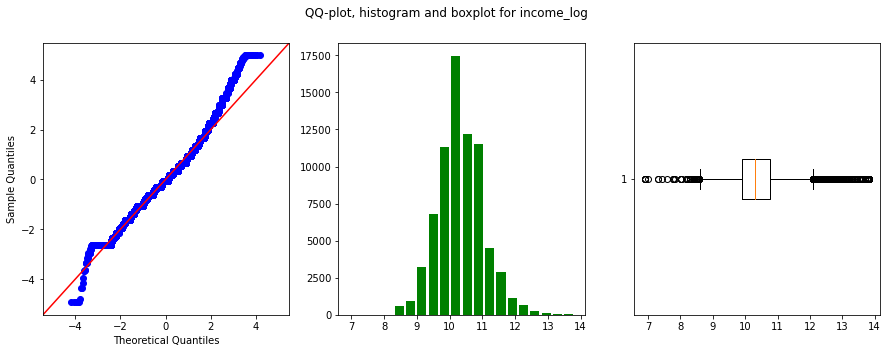

In [915]:
data_income.show_plots(log = True)

После логарифмирования признак income стал гораздо более нормальным и менее смещёнными. <br>
Посмотрим на выбросы.

In [916]:
print('Суммарное количество выбросов для income: ', data_income.outliers())
print('Суммарное количество выбросов для log(income): ', data_income.outliers(log = True))

Суммарное количество выбросов для income:  4695
Суммарное количество выбросов для log(income):  1767


После логарифмирования количество выбросов значительно уменьшилось.

In [917]:
# логарифмируем признак income
data['income'] = np.log(data['income'] + 1)
data['income'].sample(5)

68045    9.615872
76794    9.392745
81964    8.987322
41920    9.998843
10500    8.853808
Name: income, dtype: float64

***Заключение по income*** : распределение нормальное, взяли логарифм, количестов выбросов после логарифмирования уменьшилось, поэтому удалять их пока не будем. Посмотрим влияение выбросов на модель в дальнейшем.

4.3.4. days_from_ny

In [918]:
# Построим графики для income
data_days_from_ny = NumFitInspect(data[data.Train == 1], 'days_from_ny')

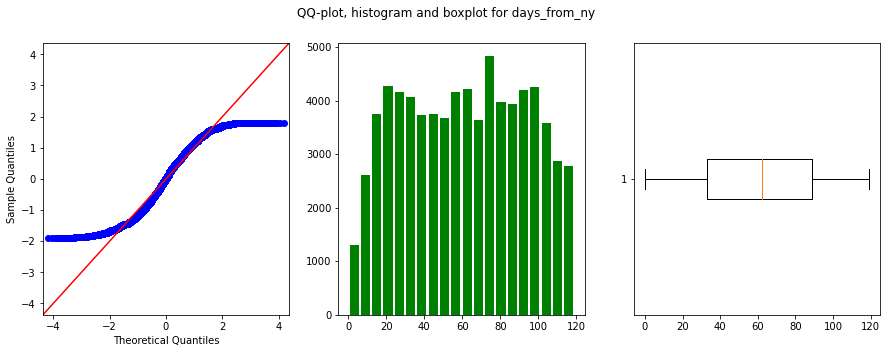

In [919]:
data_days_from_ny.show_plots()

***Заключение по days_from_ny*** : признак распределен нормально. Выбросов нет. Логарифмировать не нужно.

4.3.5. bki_request_cnt

In [920]:
# Построим графики для bki_request_cnt
data_bki_request_cnt = NumFitInspect(data[data.Train == 1], 'bki_request_cnt')

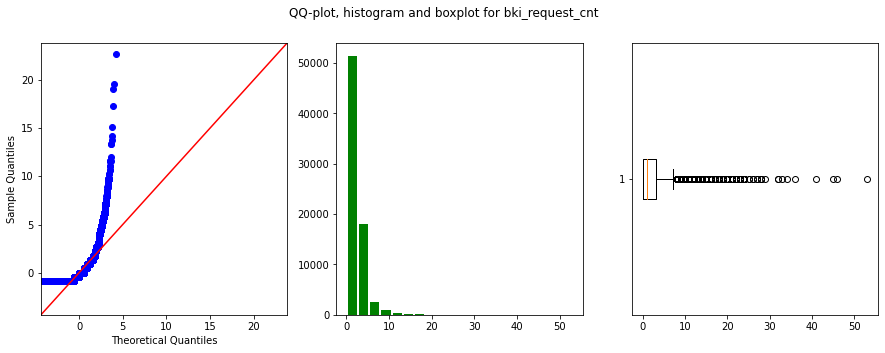

In [921]:
data_bki_request_cnt.show_plots()

Признак очень смещен. Много выбросов. <br>
Логарифмируем признак.

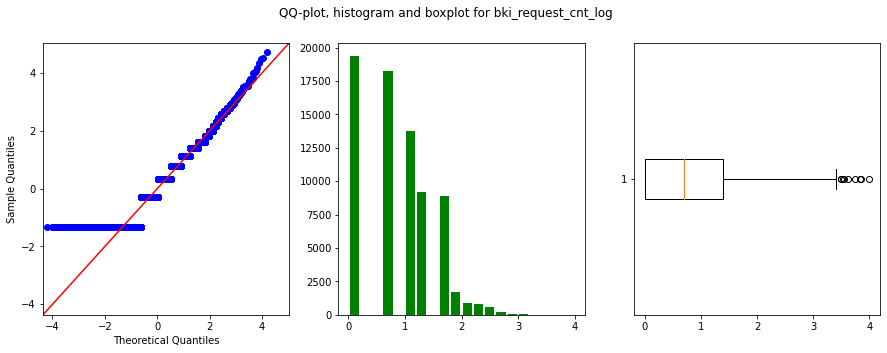

In [922]:
data_bki_request_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным. <br>
Посмотрим на выбросы.

In [923]:
print('Суммарное количество выбросов для bki_request_cnt: ', data_bki_request_cnt.outliers())
print('Суммарное количество выбросов для log(bki_request_cnt): ', data_bki_request_cnt.outliers(log = True))

Суммарное количество выбросов для bki_request_cnt:  1755
Суммарное количество выбросов для log(bki_request_cnt):  9


Количество выбросов после логарифмирования существенно уменьшилось.

In [924]:
# логарифмируем признак bki_request_cnt
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)
data['bki_request_cnt'].sample(5)

70496    1.098612
53372    0.693147
53048    1.609438
37935    1.386294
93771    1.386294
Name: bki_request_cnt, dtype: float64

***Заключение по bki_request_cnt*** : распределение нормальное, взяли логарифм, количестов выбросов после логарифмирования существенно уменьшилось, не будем их удалять.

4.3.6. score_bki

In [925]:
# Построим графики для score_bki
data_score_bki = NumFitInspect(data[data.Train == 1], 'score_bki')

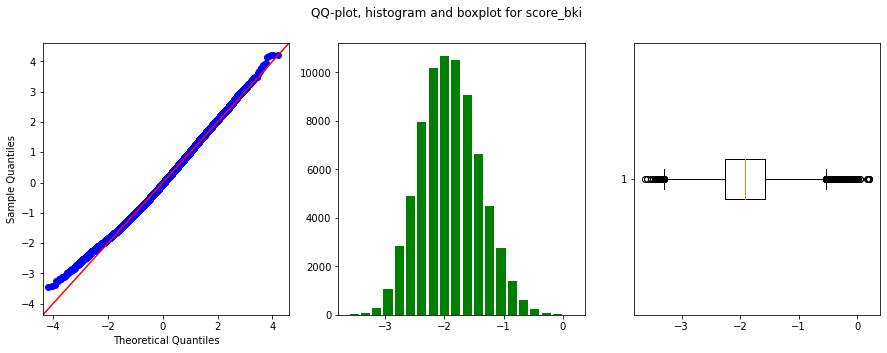

In [926]:
data_score_bki.show_plots()

Распределение, очевидно, нормальное, не смещенное. Однако, есть выбросы.

In [927]:
print('Суммарное количество выбросов для score_bki: ', data_score_bki.outliers())

Суммарное количество выбросов для score_bki:  351


***Заключение по score_bki*** : распределение нормальное, не смещенное, логарифм брать не надо, выбросов относительно не много, не будем их удалять.

Построим матрицу корреляции для числовых признаков num_cols

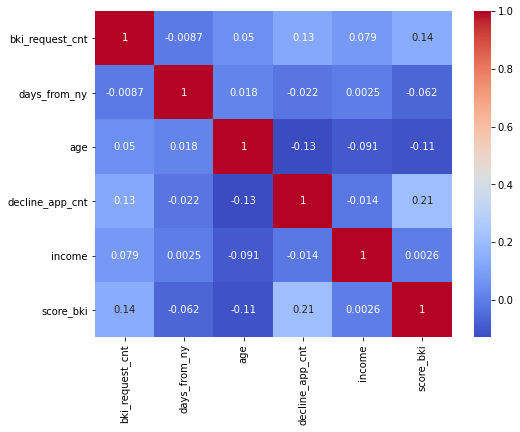

In [928]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data.loc[:,num_cols].corr(),annot = True, cmap = 'coolwarm')


Линейно-зависимых признаков нет. <br>
Посмотрим на значимость признаков для default

Значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA))
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

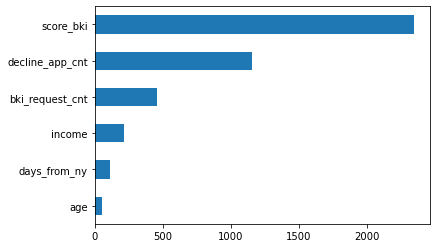

In [929]:
imp_num = pd.Series(f_classif(data[data.Train == 1][num_cols], data[data.Train == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

- наиболее значимый признак - score_bki;
- наименее значимый - age

### 4.4. Обработаем категориальные и бинарные признаки

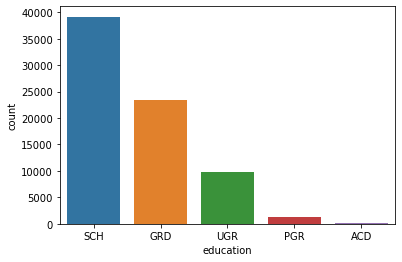

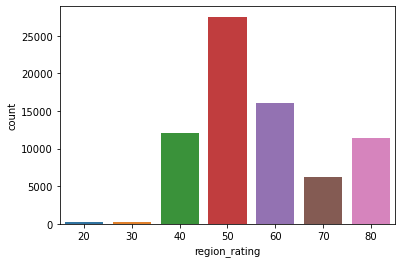

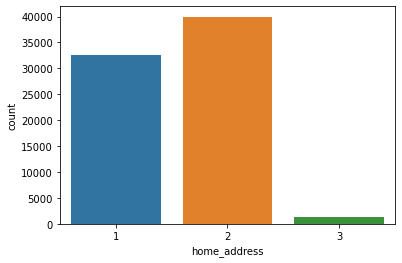

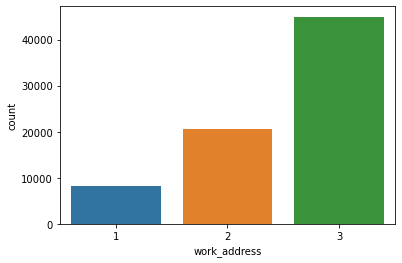

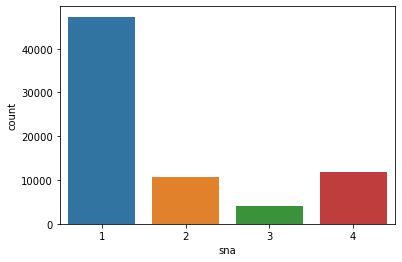

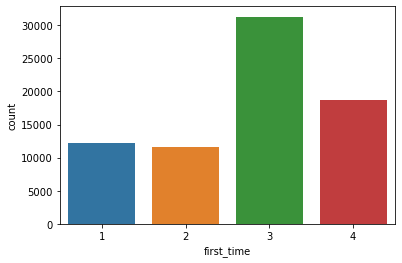

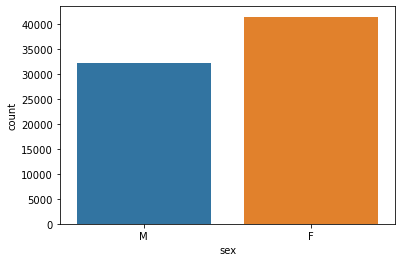

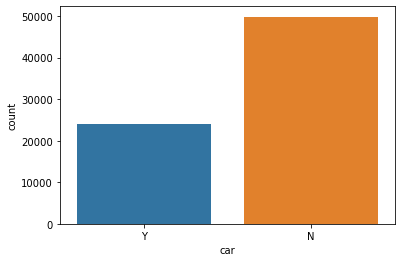

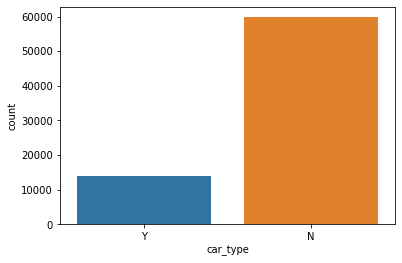

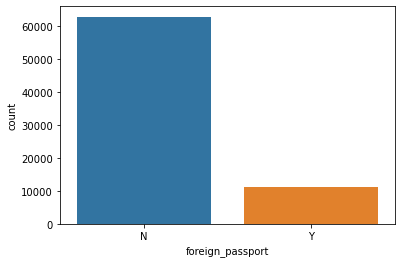

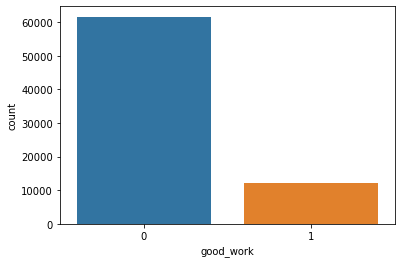

In [930]:
for col in cat_cols + bin_cols:
    plt.figure()
    sns.countplot(x=col, data=data[data.Train == 1])
    plt.show()

Закодируем категориальные признаки education и region_rating и бинарные признаки

In [931]:
# Преобразуем education в целочисленный формат
label_encoder = LabelEncoder()
data['education'] = label_encoder.fit_transform(data['education'])
data.education.unique()

array([3, 1, 4, 2, 0])

In [932]:
# Закодируем region_rating
label_encoder = LabelEncoder()
data['region_rating'] = label_encoder.fit_transform(data['region_rating'])
data.region_rating.unique()

array([3, 6, 4, 2, 5, 0, 1])

In [933]:
# Преобразуем биноминальные признаки
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    
# убедимся в преобразовании    
data.head(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days_from_ny
0,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,3,1,2,9.798183,4,1,0,0.0,1,31
1,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,3,2,3,9.852247,4,1,0,0.0,1,70
2,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,6,1,2,10.308986,1,4,1,0.0,1,31
3,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,3,2,3,9.210440,1,3,0,0.0,1,22
4,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,4,2,3,10.308986,1,4,1,0.0,1,107


In [934]:
# проверим
for column in bin_cols:
    print('Уникальные значения в поле {0} : {1}'.format(column,data[column].unique()))

Уникальные значения в поле sex : [1 0]
Уникальные значения в поле car : [1 0]
Уникальные значения в поле car_type : [1 0]
Уникальные значения в поле foreign_passport : [0 1]
Уникальные значения в поле good_work : [0 1]


Посотрим на значимость категориальных признаков

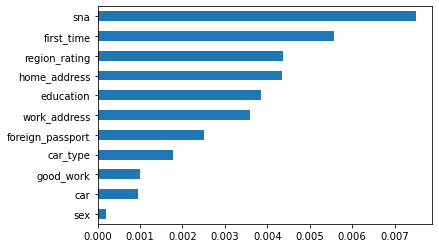

In [935]:
imp_cat = pd.Series(mutual_info_classif(data[data.Train == 1][bin_cols + cat_cols], data[data.Train == 1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

- cамый значимый признак - sna;
- наименее значимый признак - sex

# 5. Подготовим данные к ML

In [936]:
# закодируем категориальные признаки при помощи get_dummy
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_cat.sample(3)

,education_0,education_1,education_2,education_3,education_4,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
39939,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
99600,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
24284,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1


In [937]:
len(num_cols + cat_cols + bin_cols)

17

In [938]:
# стандартизиуем числовые признаки
data_num = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = num_cols)

In [939]:
# объединим все признаки в один датасет

X = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)

Y = data['default'].values

In [940]:
# проверим столбцы X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 39 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   bki_request_cnt   110148 non-null  float64
 1   days_from_ny      110148 non-null  float64
 2   age               110148 non-null  float64
 3   decline_app_cnt   110148 non-null  float64
 4   income            110148 non-null  float64
 5   score_bki         110148 non-null  float64
 6   education_0       110148 non-null  uint8  
 7   education_1       110148 non-null  uint8  
 8   education_2       110148 non-null  uint8  
 9   education_3       110148 non-null  uint8  
 10  education_4       110148 non-null  uint8  
 11  region_rating_0   110148 non-null  uint8  
 12  region_rating_1   110148 non-null  uint8  
 13  region_rating_2   110148 non-null  uint8  
 14  region_rating_3   110148 non-null  uint8  
 15  region_rating_4   110148 non-null  uint8  
 16  region_rating_5   11

In [941]:
# Проверим образец из трех строк
X.sample(3)

,bki_request_cnt,days_from_ny,age,decline_app_cnt,income,score_bki,education_0,education_1,education_2,education_3,...,first_time_2,first_time_3,first_time_4,sex,car,car_type,foreign_passport,good_work,Train,default
17071,-0.281790,1.372635,-0.249170,-0.418815,1.675407,-1.037898,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0.0
81943,-1.334144,-0.809687,0.903261,-0.418815,1.262451,-1.199652,0,0,0,0,...,0,1,0,1,0,0,0,0,0,NaN
2387,0.770563,-0.622631,1.542867,-0.418815,-1.780997,0.712649,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0.0


# 6. Построим модель

#### Разобьем датасет на тренировочный и тестовый

In [942]:
train_data = X.query('Train == 1').drop(['Train'], axis=1)
test_data = X.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

#### Выделим из тренировочного датасета 20% на валидацию

In [943]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True, random_state=RANDOM_SEED)

#### Проверим

In [944]:
print(X.shape, X_train.shape, X_test.shape)

(73799, 37) (59039, 37) (14760, 37)


#### Обучим модель

In [945]:
warnings.simplefilter('ignore')

model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

Посмотрим на метрики.

In [946]:
mi = ModelInspect(model, X_test, y_test)

#### Построим ROC-кривую

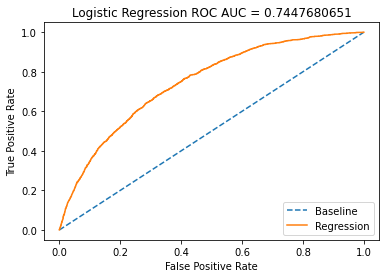

In [947]:
mi.roc_curve_plot()

Метрика ROC_AUC - достаточно велика, то есть даже без глубокого отбора и конструирования признаков нам удалось построить модель, чья предсказательная сила заметно отличается от случайного угадывания.

#### Однако посмотрим на качественные метрики

In [948]:
mi.get_metrics()

accuracy     0.874729
precision    0.394231
recall       0.022441
F1           0.042465
ROC_AUC      0.744768
dtype: float64

Confusion matrix

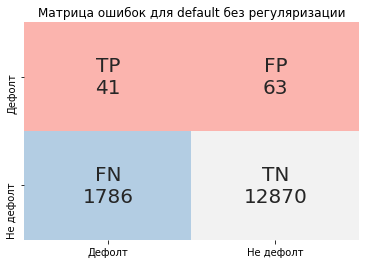

In [949]:
mi.confusion_matrix_plot()

Кривая зависимости precision от recall

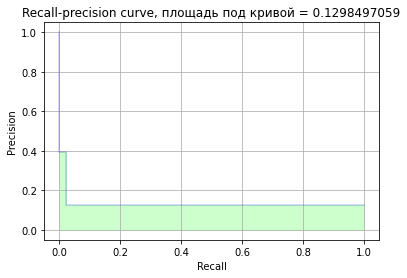

In [950]:
mi.recall_precision_plot()

***Заключение по модели без регуляризации:*** не смотря на то, что значения ROC_AUC и accuracy достаточно высоки, значения recall и F1 показывают, что предсказательная способность низкая, ошибка второго рода (пожно отрицательные, дефолт классифицирован как не-дефолт) очень высока. Это означает, что при использовании такой модели банк может понести большие убытки. <br>
Попробуем:
- сбалансировать модель;
- применить регуляризацию.

# 7. Разберемся со сбалансированностью default

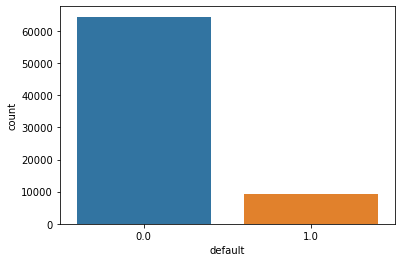

In [951]:
ax = sns.countplot(x="default", data=data)

Выборка сильно не сбалансирована. <br>
Для сглаживания влияния несбалансированности применим параметр модели
- class_weight = 'balanced' - параметр для балансировки классов


In [952]:
model = LogisticRegression(class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)
mi = ModelInspect(model, X_test, y_test)

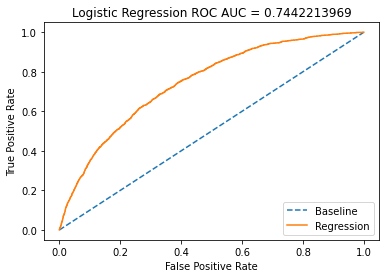

In [953]:
mi.roc_curve_plot()

In [954]:
mi.get_metrics()

accuracy     0.671070
precision    0.226715
recall       0.687466
F1           0.340980
ROC_AUC      0.744221
dtype: float64

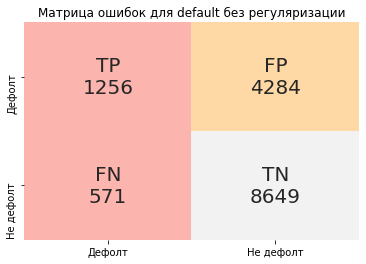

In [955]:
mi.confusion_matrix_plot()

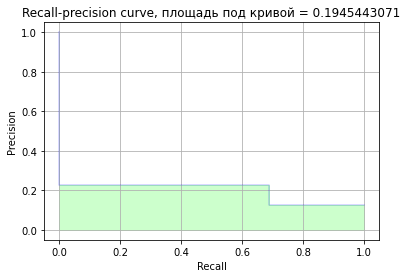

In [956]:
mi.recall_precision_plot()

Мы видим, что после применения параметра балансировки, ошибка второго рода уменьшилась, однако очень сильно возрасла ошибка первого рода (не-дефолт классифицирован как дефолт). Это означает, что при применении такой модели банк рискует недополучить прибыль. Нужно найти золотую середину.

# 8. Подберем параметры модели

In [957]:
C = np.logspace(0, 4, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [958]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# указываем модель (в нашем случае лог регрессия), гиперпараметры
model_1 = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)

In [959]:
# Обучаем модель
gridsearch = GridSearchCV(model_1, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

Лучшие значения параметров:
  C = 59.94842503189409,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = auto,
  n_jobs = None,
  penalty = l2,
  random_state = 42,
  solver = lbfgs,
  tol = 0.001,
  verbose = 0,
  warm_start = False,


In [960]:
mi = ModelInspect(model_best_params, X_test, y_test)

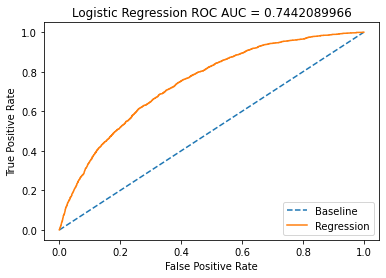

In [961]:
mi.roc_curve_plot()

In [962]:
mi.get_metrics()

accuracy     0.670799
precision    0.226551
recall       0.687466
F1           0.340795
ROC_AUC      0.744209
dtype: float64

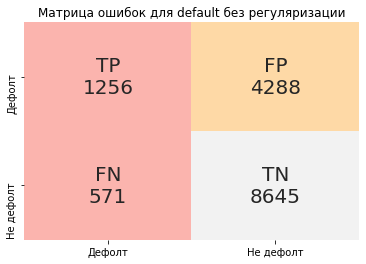

In [963]:
mi.confusion_matrix_plot()

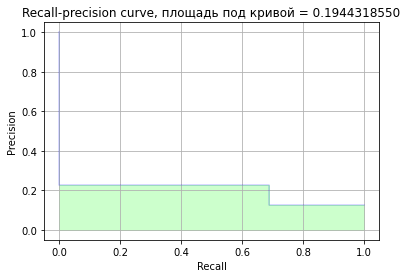

In [964]:
mi.recall_precision_plot()

# 9. Вывод
- Благодаря подбору параметров модели удалось улучшить recoll в ~ 18 раз. <br>
- Ошибка второго рода уменьшилась, мы лучше стали определять дефолтных клиентов, однако очень сильно возрасла ошибка первого рода (не-дефолт классифицирован как дефолт). Это означает, что при применении такой модели банк рискует недополучить прибыль.
- Precision и F1 также увеличились. <br>
- Тем не менее, на метрику AUC подбор параметров особо не повлиял. 

# Submission

In [965]:
y_train = train_data.default.values            
X_train = train_data.drop(['default'], axis=1)

X_test = test_data.drop(['default'], axis=1)

In [967]:
model = LogisticRegression(
  C = 59.94842503189409,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'lbfgs',
  tol = 0.001,
  verbose = 0,
  warm_start = False,
)

model.fit(X_train, y_train)

LogisticRegression(C=59.94842503189409, class_weight='balanced', max_iter=50,
                   random_state=42, tol=0.001)

In [968]:
y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

# 10. Попробуем выполнить oversampling

Попробуем решить проблемму несбалансированных данных (default = 0 в разы больше, чем default = 0) при помощи метода oversampling — увеличение кол-ва объектов классов-меньшинств

Будем использовать для этого библиотеку imbalanced-learn

In [969]:
import imblearn

In [971]:
# заново разобьев выборку (после submission)
y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

Будем использовать Synthetic Minority Oversampling Technique (SMOTE) из библиотеки imblearn

In [976]:
oversample = imblearn.over_sampling.SMOTE()
X, y = oversample.fit_resample(X, y)

In [977]:
(X.shape, y.shape)

((128854, 37), (128854,))

Посмторим как стал распределен default

In [979]:
print(len(y[y == 0]), len(y[y == 1]))

64427 64427


Мы видим, что тперь оба класса default = {0,1} распределены равномерно. <br>
Именно на этой выборке обучим модель.

In [980]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True, random_state=RANDOM_SEED)

Обучим модель и посмотрим на метрики.

In [981]:
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
mi = ModelInspect(model, X_test, y_test)

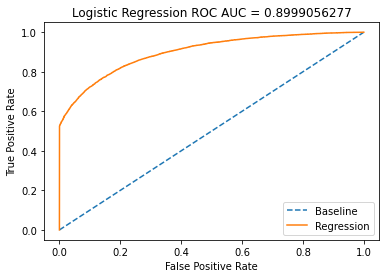

In [982]:
mi.roc_curve_plot()

In [983]:
mi.get_metrics()

accuracy     0.812386
precision    0.857764
recall       0.749263
F1           0.799851
ROC_AUC      0.899906
dtype: float64

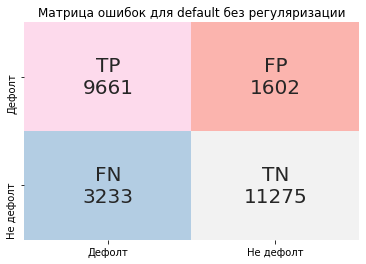

In [984]:
mi.confusion_matrix_plot()

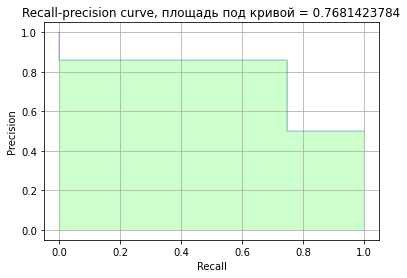

In [985]:
mi.recall_precision_plot()

На oversampling датасете модель чень хорошо показала себя. Значения метрик очень высокие. Мы увидели, как важна сбалансированность признаков и насколько сильно это влияет на качество модели.

Посмотрим, какие значения получим на тестовых данных

### Submission

In [986]:
X_test = test_data.drop(['default'], axis=1)

y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob


In [988]:
submit.to_csv('submission_ovrs.csv', index=False)

Увы, на сэмпле модель показала значения метрик гораздо ниже, AUC  0.70. Скорее всего это означает, что данные в сэмпле также очень не сбалансированные и модель повела себя не адекватно.